In [ ]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/8c/230204b8e968f6db00c765624f51cfd1ecb6aea57b25ba00b240ee3fb0bd/Pillow-5.3.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# transforms and augumentations
from torchvision import transforms

IMG_SIZE = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


train_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

In [ ]:
# upload data
from torchvision import datasets, models

train_ratio = 0.8

train_path = '/content/drive/MyDrive/ANN/archive/Malaria Cells/training_set'
test_path = '/content/drive/MyDrive/ANN/archive/Malaria Cells/testing_set'

# load in data using pytorch torchvision
train_data = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
test_data = torchvision.datasets.ImageFolder(test_path, transform=test_transform)

# split our train data into train and validation since validation data is not given
train_size = int(train_ratio * len(train_data))
val_size = len(train_data) - train_size
data_train, data_val = torch.utils.data.random_split(train_data, [train_size, val_size])



BATCH_SIZE = 34
n_classes = 2

In [ ]:
len(data_train), len(data_val), len(test_data)

(22046, 5512, 15833)

In [ ]:
# dataloader
from torch.utils.data import DataLoader

train_img_loader = DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
)
valid_Img_loader = DataLoader(
    data_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)
test_img_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

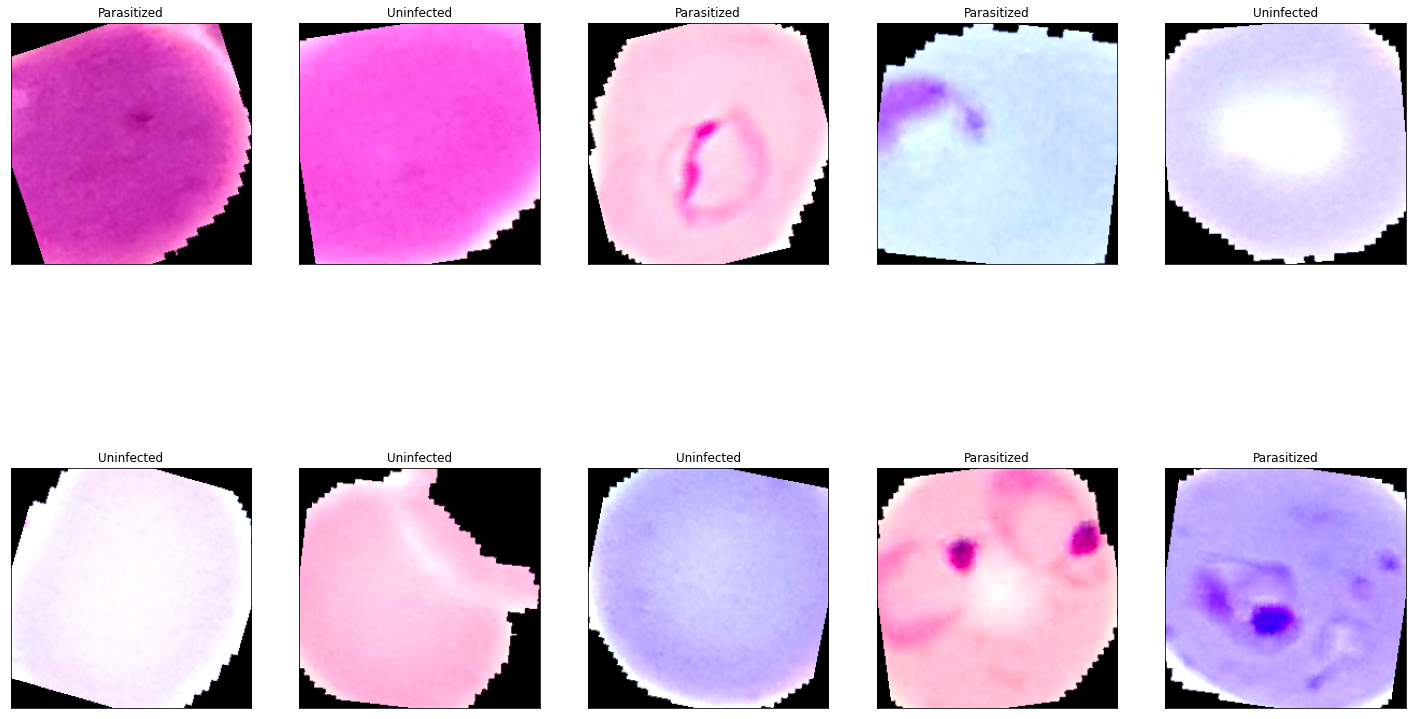

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

classes = ['Parasitized', 'Uninfected']
dataiter = iter(train_img_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 15))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks= [], yticks= [])
    imshow(images[idx]);
    ax.set_title(classes[labels[idx]])

In [ ]:
# downlaod pretrained network
model = models.resnet34(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# create fully connected layer to match our own data and classes
model.fc = nn.Sequential(nn.Linear(512, 1000),
                           nn.ReLU(),
                           nn.Dropout(0.25),
                           nn.Linear(1000, n_classes))

classifier = model.fc
model.to(device)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import torch.optim as optim
# instantiate loss function
criterion = nn.CrossEntropyLoss()
# instantiate optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003 )

In [ ]:
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_img_loader:
        # move tensors to GPU
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_Img_loader:
        # move tensors to GPU
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_img_loader.dataset)
    valid_loss = valid_loss/len(valid_Img_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_project.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 0.284827 	Validation Loss: 0.179596
Validation loss decreased (inf --> 0.179596).  Saving model ...
Epoch: 2 	Training Loss: 0.181125 	Validation Loss: 0.164410
Validation loss decreased (0.179596 --> 0.164410).  Saving model ...
Epoch: 3 	Training Loss: 0.167845 	Validation Loss: 0.155393
Validation loss decreased (0.164410 --> 0.155393).  Saving model ...
Epoch: 4 	Training Loss: 0.160628 	Validation Loss: 0.153935
Validation loss decreased (0.155393 --> 0.153935).  Saving model ...
Epoch: 5 	Training Loss: 0.154313 	Validation Loss: 0.143474
Validation loss decreased (0.153935 --> 0.143474).  Saving model ...
Epoch: 6 	Training Loss: 0.146004 	Validation Loss: 0.144092
Epoch: 7 	Training Loss: 0.146172 	Validation Loss: 0.153524
Epoch: 8 	Training Loss: 0.145229 	Validation Loss: 0.146716
Epoch: 9 	Training Loss: 0.140579 	Validation Loss: 0.132133
Validation loss decreased (0.143474 --> 0.132133).  Saving model ...
Epoch: 10 	Training Loss: 0.133686 	Valida

In [ ]:
test_loss = 0
correct = 0
total_label = 0
count = 0
sum_acc = 0
actual = []
pred = []
model.to(device)
with torch.no_grad():
  model.eval()
  for data, target in test_img_loader:
      # move tensors to GPU if CUDA is available
      
      data, target = data.to(device), target.to(device)
      actual.append(target.data.tolist())
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update average validation loss 
      test_loss += loss.item()*data.size(0)
      count += 1
      
      #Accuracy
      _, predicted = torch.max(output.data, 1)
      pred.append(predicted.data.tolist())
      #print(classification_report(target, predicted, labels=classes, digits=4))
      total_label += target.size(0)
      correct += (predicted == target).sum().item()
      acc = (correct/total_label)
      sum_acc += acc
      print (f'accuracy: {acc * 100}%')
print (f'Average Accuracy: {sum_acc/count * 100}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


accuracy: 97.05882352941177%
accuracy: 95.58823529411765%
accuracy: 97.05882352941177%
accuracy: 97.79411764705883%
accuracy: 98.23529411764706%
accuracy: 98.52941176470588%
accuracy: 98.73949579831933%
accuracy: 98.16176470588235%
accuracy: 97.7124183006536%
accuracy: 97.94117647058823%
accuracy: 97.86096256684492%
accuracy: 96.56862745098039%
accuracy: 96.38009049773756%
accuracy: 95.7983193277311%
accuracy: 95.88235294117648%
accuracy: 96.13970588235294%
accuracy: 96.02076124567473%
accuracy: 94.93464052287581%
accuracy: 95.20123839009288%
accuracy: 95.44117647058825%
accuracy: 95.09803921568627%
accuracy: 94.5187165775401%
accuracy: 94.50127877237851%
accuracy: 94.6078431372549%
accuracy: 94.47058823529412%
accuracy: 94.34389140271493%
accuracy: 94.22657952069716%
accuracy: 94.22268907563026%
accuracy: 94.01622718052738%
accuracy: 93.82352941176471%
accuracy: 93.83301707779886%
accuracy: 93.75%
accuracy: 93.85026737967914%
accuracy: 93.9446366782007%
accuracy: 93.94957983193277%
ac

In [ ]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    pred_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(_mean, _std),])
                                                    

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = pred_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
def predict_malaria(model, n_class, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    img = img.to(device)
    model = model.to(device)
    model.eval()
    idx = torch.argmax(model(img))
    return n_class[idx]

Uninfected


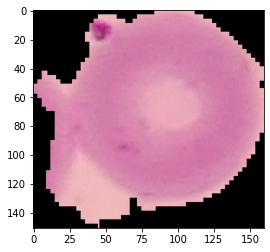

Uninfected


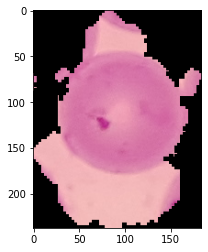

Uninfected


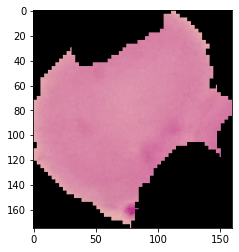

Uninfected


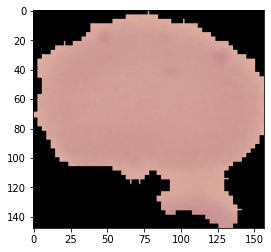

Uninfected


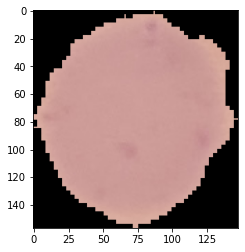

Uninfected


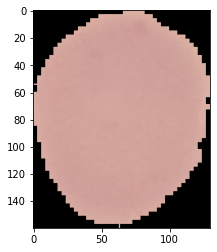

In [ ]:
from glob import glob
from PIL import Image
from termcolor import colored

n_classes=['Parasitized','Uninfected']
infected = np.array(glob("/content/drive/MyDrive/ANN/archive/Malaria Cells/training_set/Parasitized/*"))
Uninfected = np.array(glob("/content/drive/MyDrive/ANN/archive/Malaria Cells/training_set/Uninfected/*"))
for i in range(3):
    img_path=infected[i]
    img = Image.open(img_path)
    if predict_malaria(model, n_classes, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=Uninfected[i]
    img = Image.open(img_path)
    if predict_malaria(model, n_classes, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()

In [ ]:
actual

In [ ]:
predict

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
import itertools
predict = list(itertools.chain.from_iterable(pred))
results = confusion_matrix(actual, predict)
print("Report")
print(classification_report(actual, predict))
print("confustion matrix: ")
print(pd.DataFrame(results,columns=["Predicted No","Predicted Yes"],index=["Actual No", "Actual Yes"]))

Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7953
           1       0.96      0.97      0.97      7880

    accuracy                           0.97     15833
   macro avg       0.97      0.97      0.97     15833
weighted avg       0.97      0.97      0.97     15833

confustion matrix: 
            Predicted No  Predicted Yes
Actual No           7638            315
Actual Yes           229           7651
